In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df1 = pd.read_csv('product.csv',index_col = 'PRODUCT_ID')
df2 = pd.read_csv('coupon.csv')
df2 = df2.drop_duplicates(keep='first')
df3 = pd.read_csv('campaign_desc.csv')
df4 = pd.read_csv('transaction_data.csv')
df5 = pd.read_csv('hh_demographic.csv')

In [6]:
def calc_cust_price (row):
    return (row['SALES_VALUE']+row['COUPON_DISC'])

df4['CUST_PAY'] = df4.apply(lambda row: calc_cust_price(row), axis=1)

### Vegetarian or not?

In [4]:
df1['DEPARTMENT'].unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

In [68]:
meat = ['MEAT', 'MEAT-PCKGD', 'SEAFOOD-PCKGD', 'SEAFOOD', 'PORK']
produce = ['PRODUCE']
meat_products = df1[df1['DEPARTMENT'].isin(meat)].index
produce_products = df1[df1['DEPARTMENT'].isin(produce)].index

meat_tran = df4[df4['PRODUCT_ID'].isin(meat_products)]
produce_tran = df4[df4['PRODUCT_ID'].isin(produce_products)]

meat_tran = meat_tran.groupby('household_key').agg('sum').filter(['CUST_PAY']).rename(columns={'CUST_PAY':'meat'})
produce_tran = produce_tran.groupby('household_key').agg('sum').filter(['CUST_PAY']).rename(columns={'CUST_PAY':'produce'})
total_tran = df4.groupby('household_key').agg('sum').filter(['CUST_PAY']).rename(columns={'CUST_PAY':'total'})

overall = meat_tran.join(produce_tran, how='outer').join(total_tran, how='outer')
overall.fillna(0, inplace = True) 

overall['meat_frac'] = overall.apply(lambda row: row['meat']/row['total'], axis=1)
overall['produce_frac'] = overall.apply(lambda row: row['produce']/row['total'], axis=1)



Text(0, 0.5, 'Fraction of spending on produce')

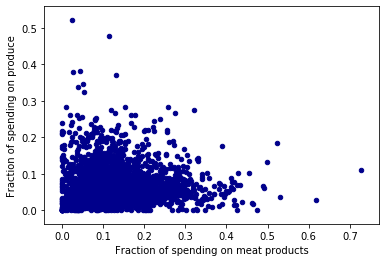

In [71]:
overall.plot.scatter(x='meat_frac', y='produce_frac', c='DarkBlue')
plt.xlabel('Fraction of spending on meat products')
plt.ylabel('Fraction of spending on produce')

In [73]:
temp = overall.filter(['meat_frac', 'produce_frac'])
temp = temp.reset_index(drop=True)

from sklearn.cluster import KMeans
y_pred = KMeans(n_clusters=3).fit_predict(temp)


Text(0, 0.5, 'Fraction of spending on produce')

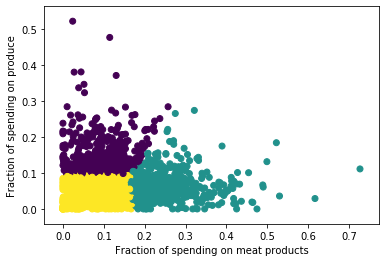

In [75]:
#plt.figure(figsize=(8, 8))
plt.scatter(temp['meat_frac'], temp['produce_frac'], c=y_pred)
plt.xlabel('Fraction of spending on meat products')
plt.ylabel('Fraction of spending on produce')

### Car owning

In [76]:
fuel_prod = df1[df1['DEPARTMENT']=='KIOSK-GAS'].index
df_fuel = df4.filter(['PRODUCT_ID', 'household_key', 'CUST_PAY'])
df_fuel['FUEL'] = df_fuel['PRODUCT_ID'].isin(fuel_prod)
df_fuel1 = df_fuel.groupby('household_key').agg('sum')
y_pred = KMeans(n_clusters=3).fit_predict(df_fuel1.filter(['FUEL']))

Text(0, 0.5, 'Amount spend on gas')

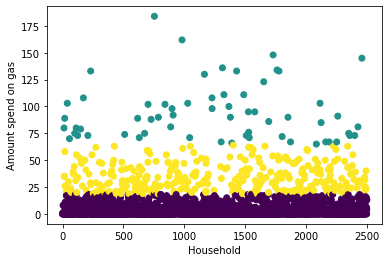

In [77]:
plt.scatter(range(2500),df_fuel1['FUEL'], c=y_pred)
plt.xlabel('Household')
plt.ylabel('Amount spend on gas')

### Children

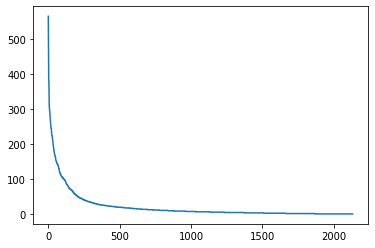

In [10]:
child_subcomm = ['TRICYCLES/WAGONS/ETC', 'SEASONAL PRESHCOOL', 'OTHER PRESCHOOL','BABY DOLL ACCESSORIES',  \
                'BARBIE', 'PRESCHOOL TOYS', 'CHILDREN S ACTIVITY', '*BOYS/GIRLS MISC TOYS', 'SEASONAL BARBIE', \
                'CHILDREN S MUSICAL INSTRUMENTS', 'CHILDRENS LOW END', 'CHILDRENS  BOOKS']
child_comm = ['PNT BTR/JELLY/JAMS', 'BABY HBC', 'BABY FOODS', 'INFANT CARE PRODUCTS', \
              'DIAPERS & DISPOSABLES', 'BABYFOOD']

df_child_prod = df1[df1['COMMODITY_DESC'].isin(child_comm)]
df_child_prod = df_child_prod.append(df1[df1['SUB_COMMODITY_DESC'].isin(child_subcomm)])
df_child_prod = df_child_prod.index

child_tran = df4[df4['PRODUCT_ID'].isin(df_child_prod)]
child_tran = child_tran.groupby('household_key').count().\
                filter(['BASKET_ID']).\
                rename(columns={'BASKET_ID':'num_tran'}).\
                sort_values('num_tran', ascending=False)
plt.plot(child_tran['num_tran'].tolist())

In [30]:
df5

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16
...,...,...,...,...,...,...,...,...
796,35-44,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2494
797,45-54,A,75-99K,Homeowner,Unknown,3,1,2496
798,45-54,U,35-49K,Unknown,Single Male,1,None/Unknown,2497
799,25-34,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2498


In [22]:
child_tran['num_tran'].shape

(2133,)

(array([1.946e+03, 1.000e+02, 4.100e+01, 2.200e+01, 1.200e+01, 6.000e+00,
        3.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]),
 array([  1. ,  57.3, 113.6, 169.9, 226.2, 282.5, 338.8, 395.1, 451.4,
        507.7, 564. ]),
 <a list of 10 Patch objects>)

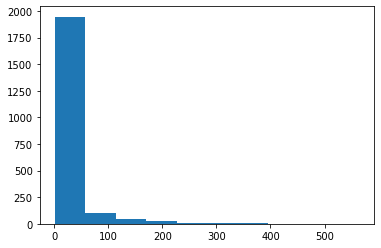

In [20]:
plt.hist(child_tran['num_tran'].tolist())

### Halloween

In [78]:
halloween_prod = df1[df1['COMMODITY_DESC']=='HALLOWEEN'].index
week_wise_sales = df4[df4['PRODUCT_ID'].isin(halloween_prod)].\
                filter(['WEEK_NO', 'SALES_VALUE']).\
                groupby('WEEK_NO').agg('sum')

Text(0, 0.5, 'Total sales on Halloween products')

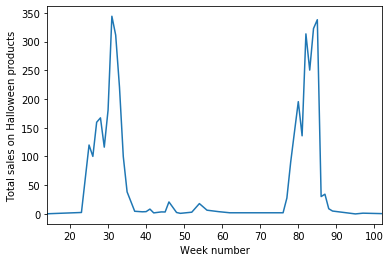

In [81]:
week_wise_sales.plot(y='SALES_VALUE', legend=None)
plt.xlabel('Week number')
plt.ylabel('Total sales on Halloween products')

### Organic food

Text(0, 0.5, 'Median spending on Organic goods per household')

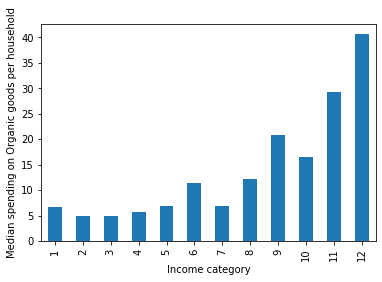

In [85]:
df_organic = df1[df1['COMMODITY_DESC']=='ORGANICS FRUIT & VEGETABLES'].index.tolist()
sales_h = df4[df4['PRODUCT_ID'].isin(df_organic)].\
            groupby('household_key').\
            agg('sum').\
            reset_index()\
            [['household_key','CUST_PAY']].\
            set_index('household_key')

df5.set_index('household_key').join(sales_h, how='left')[['INCOME_DESC','CUST_PAY']].\
            reset_index().\
            groupby('INCOME_DESC').\
            agg('median').\
            reset_index().replace({'Under 15K': 1, '15-24K' : 2, '25-34K': 3, '35-49K' : 4, '50-74K' : 5, '75-99K' : 6, '100-124K' : 7, '125-149K' : 8, '150-174K' : 9, '175-199K' : 10, '200-249K' : 11, '250K+' : 12})\
            .sort_values('INCOME_DESC')\
            .set_index('INCOME_DESC')['CUST_PAY'].plot(kind='bar')

plt.xlabel('Income category')
plt.ylabel('Median spending on Organic goods per household')

In the above we used the median instead of the mean, because even if one family spends a lot or spends very little, then the mean changes a lot, due to the small size of data we how. Median is a more robust statistics in this case.

### Cookies and milk

In [38]:
df1[df1['SUB_COMMODITY_DESC']=='SPECIALTY COOKIES']['CURR_SIZE_OF_PRODUCT'].unique()

array(['14 OZ', '12 OZ', '16 OZ', '6 OZ', '14.1 OZ', '13 OZ', '7 OZ',
       '12.3 OZ', '5.25 OZ', '6.88 OZ', '5.29 OZ', '3.5 OZ', '5.5 OZ',
       '10.6 OZ', '8 OZ', '7.05 OZ', '4.93 OZ', '5.28 OZ', '5.3 OZ',
       '9 OZ', '11 OZ', '4.4 OZ', '10 OZ', '3.52 OZ', '4.5 OZ', '6.5 OZ',
       '3.5OZ', '13.5 OZ', '5.52 OZ', '3.2 OZ', '4.86 OZ', '11.4 OZ',
       '6.4 OZ', '5.3OZ', '8.9 OZ', '6.17OZ', ' ', '4       OZ',
       '14.5 OZ', '2 OZ', '24.69 OZ', '5.7 OZ', '6.1 OZ'], dtype=object)

In [56]:
m = {}
for x in df1['SUB_COMMODITY_DESC']: 
    if 'egg' in x.lower():
        #print(x)
        if x not in m:
           m[x] = 0 
        m[x] += 1
for k, x in m.items():
    print(k, x)

EGGS - X-LARGE 14
EGGS - MEDIUM 17
EGGS SUBSTITUTE 25
LEGGS 142
EGGS - LARGE 55
MALTED MLK/SYRUP/PWDRS (EGGNOG 53
EGG NOG/BOILED CUSTARD 21
EGGS - JUMBO 10
EASTER EGG COLORING 17
EGGS 16
FRZN EGG SUBSTITUTES 2
EASTER FILL EGGS 31


In [55]:
df1[df1['SUB_COMMODITY_DESC']=='LEGGS']#['CURR_SIZE_OF_PRODUCT'].unique()

,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
PRODUCT_ID,,,,,,
35407,1944,DRUG GM,National,HOSIERY/SOCKS,LEGGS,
112413,1944,DRUG GM,National,HOSIERY/SOCKS,LEGGS,
821238,1944,DRUG GM,National,HOSIERY/SOCKS,LEGGS,
827954,1944,DRUG GM,National,HOSIERY/SOCKS,LEGGS,
830593,1944,DRUG GM,National,HOSIERY/SOCKS,LEGGS,
...,...,...,...,...,...,...
10255421,1944,DRUG GM,National,HOSIERY/SOCKS,LEGGS,
10255482,1944,DRUG GM,National,HOSIERY/SOCKS,LEGGS,
15686743,2187,DRUG GM,National,HOSIERY/SOCKS,LEGGS,MED/TALL
